## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/w266 project/dontpatronizeme/semeval-2022')
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/w266 project/dontpatronizeme/semeval-2022'

In [2]:
import random
import os
from urllib import request
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt


from sklearn.model_selection import StratifiedKFold,train_test_split,KFold
from collections import Counter,defaultdict
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer
from sklearn.metrics import classification_report



In [3]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

## Data

In [4]:
from dont_patronize_me import DontPatronizeMe
dpm = DontPatronizeMe('data', 'data')
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [5]:
trids = pd.read_csv('practice splits/train_semeval_parids-labels.csv')
teids = pd.read_csv('practice splits/dev_semeval_parids-labels.csv') 
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)
print(trids.shape)
print(teids.shape)

(8375, 2)
(2094, 2)


In [6]:
# Rebuild train set for Task 1
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })

trdf1 = pd.DataFrame(rows)

# Rebuild test set for Task 1
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })

tedf1 = pd.DataFrame(rows)

# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])
training_set1

,par_id,text,label
0,4341,"The scheme saw an estimated 150,000 children f...",1
1,4136,Durban 's homeless communities reconciliation ...,1
2,10352,The next immediate problem that cropped up was...,1
3,8279,Far more important than the implications for t...,1
4,1164,To strengthen child-sensitive social protectio...,1
...,...,...,...
2377,1775,Last but not the least element of culpability ...,0
2378,1776,"Then , taking the art of counter-intuitive non...",0
2379,1777,Kagunga village was reported to lack necessary...,0
2380,1778,"""After her parents high-profile divorce after ...",0


In [7]:
import numpy as np
np.mean(tedf1.label)

0.09503342884431709

In [8]:
# Rebuild train set for task 2
rows2 = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  label = trids.label[idx]
  # select row from original dataset to retrieve the `text` value
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  rows2.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  
trdf2 = pd.DataFrame(rows2)
trdf2.label = trdf2.label.apply(ast.literal_eval)

rows2 = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  label = teids.label[idx]
  #print(parid)
  # select row from original dataset to access the `text` value
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  rows2.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  
tedf2 = pd.DataFrame(rows2)
tedf2.label = tedf2.label.apply(ast.literal_eval)

# downsample
all_negs = trdf2[trdf2.label.apply(lambda x:sum(x) == 0)]
all_pos = trdf2[trdf2.label.apply(lambda x:sum(x) > 0)]

training_set2 = pd.concat([all_pos,all_negs[:round(len(all_pos)*0.5)]])
training_set2

,par_id,text,label
0,4341,"The scheme saw an estimated 150,000 children f...","[1, 0, 0, 1, 0, 0, 0]"
1,4136,Durban 's homeless communities reconciliation ...,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,The next immediate problem that cropped up was...,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,Far more important than the implications for t...,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,To strengthen child-sensitive social protectio...,"[1, 0, 0, 1, 1, 1, 0]"
...,...,...,...
1186,434,""""""" I was absolutely useless at school , hopel...","[0, 0, 0, 0, 0, 0, 0]"
1187,435,I also noticed the change in socio-economic le...,"[0, 0, 0, 0, 0, 0, 0]"
1188,436,"Can Donald Trump win ? It 's possible , but ce...","[0, 0, 0, 0, 0, 0, 0]"
1189,437,He added that any introduction of new law must...,"[0, 0, 0, 0, 0, 0, 0]"


## Modeling

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers, regularizers, metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier


In [13]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

def plot_history_auc(history):
  auc = history.history['auc']
  val_auc = history.history['val_auc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(auc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, auc, 'b', label='Training auc')
  plt.plot(x, val_auc, 'r', label='Validation auc')
  plt.title('Training and validation AUC')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

In [14]:
sentences_train = training_set1['text'].values
y_train = training_set1['label'].values

sentences_test = tedf1['text'].values
y_test = tedf1['label'].values

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test = vectorizer.transform(sentences_test)

### Random baseline

In [ ]:
y_predict = [random.choice([0,1]) for k in range(len(teids))]
f1_score(y_test, y_predict)

0.1680129240710824

### Logistic Regression BOW

In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_predict = classifier.predict(X_test)

#score = classifier.score(X_test, y_test)
#print("Accuracy:", score)
f1_score(y_test, y_predict)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.33684210526315794

In [ ]:
y_predict = classifier.predict_proba(X_test)[:,1]
y_predict

array([0.99869061, 0.58298737, 0.31375128, ..., 0.06966969, 0.66389236,
       0.4264955 ])

In [ ]:
np.logspace(0.001, 0.999, num=20)

array([1.00230524, 1.13116593, 1.27659351, 1.44071788, 1.6259428 ,
       1.83498103, 2.07089412, 2.33713721, 2.63760967, 2.97671216,
       3.35941114, 3.79131155, 4.27873894, 4.8288321 , 5.44964762,
       6.15027786, 6.94098415, 7.83334706, 8.840436  , 9.97700064])

In [ ]:
for threshold in np.linspace(0, 1, num=21):
    y_predict_bin = [1 if i>threshold else 0 for i in y_predict]
    print('Threshold:', np.round(threshold,3), 
          '| Accuracy: ', np.round(np.mean(np.array(y_predict_bin) == np.array(y_test)), 4),
          '| F1:', np.round(f1_score(y_test, y_predict_bin), 4))

Threshold: 0.0 | Accuracy:  0.095 | F1: 0.1736
Threshold: 0.05 | Accuracy:  0.3964 | F1: 0.2274
Threshold: 0.1 | Accuracy:  0.5239 | F1: 0.2587
Threshold: 0.15 | Accuracy:  0.596 | F1: 0.2806
Threshold: 0.2 | Accuracy:  0.6605 | F1: 0.2981
Threshold: 0.25 | Accuracy:  0.703 | F1: 0.3165
Threshold: 0.3 | Accuracy:  0.7297 | F1: 0.3213
Threshold: 0.35 | Accuracy:  0.7617 | F1: 0.332
Threshold: 0.4 | Accuracy:  0.7846 | F1: 0.3299
Threshold: 0.45 | Accuracy:  0.8042 | F1: 0.3366
Threshold: 0.5 | Accuracy:  0.8195 | F1: 0.3368
Threshold: 0.55 | Accuracy:  0.8343 | F1: 0.3365
Threshold: 0.6 | Accuracy:  0.8438 | F1: 0.3173
Threshold: 0.65 | Accuracy:  0.8558 | F1: 0.3229
Threshold: 0.7 | Accuracy:  0.8663 | F1: 0.3069
Threshold: 0.75 | Accuracy:  0.8758 | F1: 0.2935
Threshold: 0.8 | Accuracy:  0.8806 | F1: 0.269
Threshold: 0.85 | Accuracy:  0.8849 | F1: 0.2397
Threshold: 0.9 | Accuracy:  0.8926 | F1: 0.1636
Threshold: 0.95 | Accuracy:  0.9007 | F1: 0.1333
Threshold: 1.0 | Accuracy:  0.905 |

In [ ]:
y_predict_bin = [1 if i>0.5 else 0 for i in y_predict]

### NN w/ CountVectorizer

In [ ]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(5, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.01)))
model.add(layers.Dense(3, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.01)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
              optimizer=tf.keras.optimizers.Adam(0.0005), 
              metrics=['acc'])
#model.summary()

history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=8)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

y_predict = model.predict(X_test)
y_predict = [1 if i[0]>0.5 else 0 for i in y_predict]

#plot_history(history)
f1_score(y_test, y_predict)


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_18/dense_54/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_18/dense_54/embedding_lookup_sparse/Reshape:0", shape=(None, 5), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_18/dense_54/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


298/298 [==============================] - 6s 12ms/step - loss: 0.7505 - acc: 0.6658 - val_loss: 0.5618 - val_acc: 0.9050
Epoch 2/10
298/298 [==============================] - 3s 9ms/step - loss: 0.6742 - acc: 0.6667 - val_loss: 0.5463 - val_acc: 0.9050
Epoch 3/10
298/298 [==============================] - 3s 9ms/step - loss: 0.6557 - acc: 0.6667 - val_loss: 0.5227 - val_acc: 0.9050
Epoch 4/10
298/298 [==============================] - 3s 9ms/step - loss: 0.6359 - acc: 0.7175 - val_loss: 0.5320 - val_acc: 0.8825
Epoch 5/10
298/298 [==============================] - 3s 9ms/step - loss: 0.6211 - acc: 0.7636 - val_loss: 0.5092 - val_acc: 0.8854
Epoch 6/10
298/298 [==============================] - 3s 9ms/step - loss: 0.6044 - acc: 0.7834 - val_loss: 0.5450 - val_acc: 0.8601
Epoch 7/10
298/298 [==============================] - 3s 9ms/step - loss: 0.5903 - acc: 0.8039 - val_loss: 0.5537 - val_acc: 0.8577
Epoch 8/10
298/298 [==============================] - 3s 9ms/step - loss: 0.5772 - acc

0.33978494623655914

### CNN Single Channel w/ GloVe

In [15]:
# tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

The next immediate problem that cropped up was how to assist the unfortunate couple , as neither of them possessed a birth certificate , a marriage certificate , or even an identity card . The Samurdhi Officer Dhanapala lamented explaining how agonizing it was for him to bear , when he came across the majority of poor families in the village did not possess even an ID to assist them officially .
[1, 335, 1366, 432, 8, 4248, 79, 19, 92, 2, 794, 1, 1055, 1525, 13, 1948, 3, 50, 6381, 6, 897, 3285, 6, 1236, 3285, 41, 109, 34, 1056, 1146, 1, 6382, 1237, 6383, 6384, 6385, 92, 6386, 16, 19, 7, 130, 2, 1949, 64, 26, 397, 201, 1, 398, 3, 37, 38, 5, 1, 607, 187, 27, 2661, 109, 34, 2662, 2, 794, 50, 4249]


In [16]:
# padding
maxlen = 128

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[2, :])

[   1  335 1366  432    8 4248   79   19   92    2  794    1 1055 1525
   13 1948    3   50 6381    6  897 3285    6 1236 3285   41  109   34
 1056 1146    1 6382 1237 6383 6384 6385   92 6386   16   19    7  130
    2 1949   64   26  397  201    1  398    3   37   38    5    1  607
  187   27 2661  109   34 2662    2  794   50 4249    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [18]:
# download embedding
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

path_to_glove_file = 'glove.6B.300d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

--2022-04-05 03:53:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-05 03:53:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-05 03:53:48--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [19]:
# create embeddng matrix
num_tokens = vocab_size
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 12966 words (612 misses)


In [20]:
def create_model(num_filters, kernel_size, n_dense, l2):
  model = Sequential()

  model.add(layers.Embedding(input_dim=vocab_size, 
                            output_dim=embedding_dim, 
                            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                            trainable=False,
                            input_length=maxlen))

  model.add(layers.Conv1D(
      filters=num_filters, 
      kernel_size=kernel_size, 
      strides=1, 
      padding='same', 
      activation='relu', 
      use_bias=True,
      kernel_initializer='glorot_uniform', 
      bias_initializer='zeros'))    

  model.add(layers.GlobalMaxPooling1D())

  model.add(layers.Dense(n_dense, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0, l2=l2)))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=[metrics.AUC(name='auc')])

  #model.summary()
  return model

model = create_model(128, 5, 256, 1e-05)

In [21]:
from sklearn.metrics import roc_auc_score
def recall_m(y_true, y_pred):
  y_true = tf.cast(y_true, 'float32')
  y_pred = tf.reshape(tf.cast(y_pred, 'float32'), [-1])
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = TP / (Positives+K.epsilon())    
  return recall 
    
def precision_m(y_true, y_pred):
  y_true = tf.cast(y_true, 'float32')
  y_pred = tf.reshape(tf.cast(y_pred, 'float32'), [-1])
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))   
  precision = TP / (Pred_Positives+K.epsilon())
  return precision

def custom_f1(y_true, y_pred):     
  precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras import backend as K
set_random_seed(1)

In [23]:
# train
for epoch in range(10):
  model.fit(X_train, y_train,
                    epochs=1,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=32)
  
  y_predict_values = model.predict(X_test, batch_size=32, verbose=True)  

  print('Validation')
  print('AUC:', roc_auc_score(y_test, y_predict_values))
  
  for threshold in [0.5, 0.7, 0.9, 0.99, 0.999]:
    y_predict = [1 if i[0]>threshold else 0 for i in y_predict_values]
    print('Threshold:', threshold, 
          '| Precision:', np.round(precision_m(y_test, y_predict).numpy(),4),
          '| Recall:', np.round(recall_m(y_test, y_predict).numpy(),4),
          '| F1:', np.round(f1_score(y_test, y_predict),4))

66/66 [==============================] - 0s 2ms/step
Validation
AUC: 0.8090929581946672
Threshold: 0.5 | Precision: 0.237 | Recall: 0.6181 | F1: 0.3426
Threshold: 0.7 | Precision: 0.3245 | Recall: 0.2462 | F1: 0.28
Threshold: 0.9 | Precision: 1.0 | Recall: 0.0151 | F1: 0.0297
Threshold: 0.99 | Precision: 0.0 | Recall: 0.0 | F1: 0.0
Threshold: 0.999 | Precision: 0.0 | Recall: 0.0 | F1: 0.0
66/66 [==============================] - 0s 1ms/step
Validation
AUC: 0.8205751713713687
Threshold: 0.5 | Precision: 0.3127 | Recall: 0.4824 | F1: 0.3794
Threshold: 0.7 | Precision: 0.4071 | Recall: 0.2864 | F1: 0.3363
Threshold: 0.9 | Precision: 0.6129 | Recall: 0.0955 | F1: 0.1652
Threshold: 0.99 | Precision: 0.0 | Recall: 0.0 | F1: 0.0
Threshold: 0.999 | Precision: 0.0 | Recall: 0.0 | F1: 0.0
66/66 [==============================] - 0s 2ms/step
Validation
AUC: 0.8270097187785895
Threshold: 0.5 | Precision: 0.1165 | Recall: 0.995 | F1: 0.2085
Threshold: 0.7 | Precision: 0.1306 | Recall: 0.9799 | F1: 

Epoch 1/5
120/120 [==============================] - 11s 14ms/step - loss: 0.6088 - auc: 0.6562 - val_loss: 0.4116 - val_auc: 0.7927
Epoch 2/5
120/120 [==============================] - 1s 11ms/step - loss: 0.4448 - auc: 0.8656 - val_loss: 0.4132 - val_auc: 0.8134
Epoch 3/5
120/120 [==============================] - 1s 12ms/step - loss: 0.3045 - auc: 0.9504 - val_loss: 0.3215 - val_auc: 0.8196
Epoch 4/5
120/120 [==============================] - 1s 11ms/step - loss: 0.1574 - auc: 0.9928 - val_loss: 0.3386 - val_auc: 0.8168
Epoch 5/5
120/120 [==============================] - 1s 11ms/step - loss: 0.0596 - auc: 0.9998 - val_loss: 0.3716 - val_auc: 0.8213
Training AUC: 1.0000
Testing AUC:  0.8213


0.3803921568627451

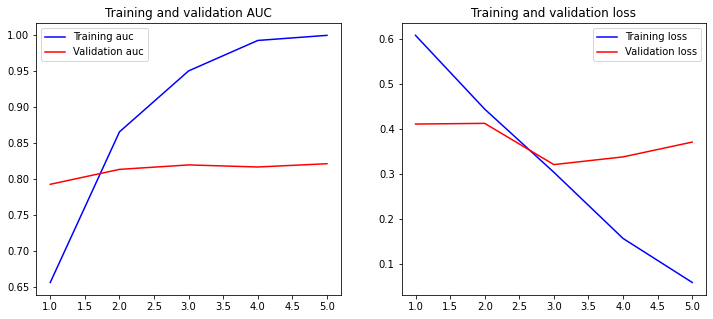

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=20)

loss, AUC = model.evaluate(X_train, y_train, verbose=False)
print("Training AUC: {:.4f}".format(AUC))
loss, AUC = model.evaluate(X_test, y_test, verbose=False)
print("Testing AUC:  {:.4f}".format(AUC))
plot_history_auc(history)

y_predict = model.predict(X_test)
y_predict = [1 if i[0]>0.5 else 0 for i in y_predict]
f1_score(y_test, y_predict)

#### Hyperparameter Tuning

In [ ]:
param_grid = dict(num_filters = [32, 64, 128],
                  kernel_size = [3, 5, 7],
                  n_dense = [20, 50, 100],
                  l2 = [0, 0.00001, 0.001])

model = KerasClassifier(build_fn = create_model,
                        epochs=10, batch_size=20, 
                        verbose=False)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          scoring='f1',
                          cv=4, verbose=1, n_iter=5, random_state=0)

grid_result = grid.fit(X_train, y_train)
grid.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


Fitting 4 folds for each of 5 candidates, totalling 20 fits


0.35278154681139756

In [ ]:
#grid_result.best_score_
grid_result.best_params_

{'kernel_size': 3, 'l2': 1e-05, 'n_dense': 50, 'num_filters': 64}

### BERT

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.4 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 895 kB 38.6 MB/s 
     |████████████████████████████████| 6.5 MB 26.2 MB/s 
     |████████████████████████████████| 596 kB 40.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import tensorflow as tf

import transformers

from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import backend as K

import logging
tf.get_logger().setLevel(logging.ERROR)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
max_length = 150

x_train = tokenizer([str(x) for x in training_set1['text'].values], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_train = training_set1['label'].values

x_test = tokenizer([str(x) for x in tedf1['text'].values], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_test = tedf1['label'].values

In [ ]:
def create_classification_model(hidden_size = 200, 
                                train_layers = -1, 
                                optimizer=tf.keras.optimizers.Adam()):
    """
    Build a simple classification model with BERT. Let's keep it simple and don't add dropout, layer norms, etc.
    """

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                  'token_type_ids': token_type_ids,
                  'attention_mask': attention_mask}


    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False


    bert_out = bert_model(bert_inputs)


    classification_token = tf.keras.layers.Lambda(lambda x: x[:,0,:], name='get_first_vector')(bert_out[0])


    hidden = tf.keras.layers.Dense(hidden_size, name='hidden_layer')(classification_token)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], 
                                          outputs=[classification])
    
    classification_model.compile(optimizer=optimizer,
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                            metrics='accuracy')


    return classification_model

In [ ]:
classification_model = create_classification_model() 

In [ ]:
classification_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
                         y_train,
                         validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask],
                         y_test),
                        epochs=3,
                        batch_size=8)

Epoch 1/3
298/298 [==============================] - 269s 757ms/step - loss: 0.9158 - accuracy: 0.5831 - val_loss: 0.3141 - val_accuracy: 0.9050
Epoch 2/3
298/298 [==============================] - 215s 721ms/step - loss: 0.6945 - accuracy: 0.6171 - val_loss: 0.4775 - val_accuracy: 0.9050
Epoch 3/3
298/298 [==============================] - 214s 720ms/step - loss: 0.6739 - accuracy: 0.6310 - val_loss: 0.3684 - val_accuracy: 0.9050


In [ ]:
try:
    del classification_model
except:
    pass

try:
    del bert_model
except:
    pass

tf.keras.backend.clear_session()

bert_model = TFBertModel.from_pretrained('bert-base-cased')

classification_model = create_classification_model(optimizer=tf.keras.optimizers.Adam(0.00005))

classification_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
                         y_train,
                         validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask],
                         y_test),
                        epochs=3,
                        batch_size=8)

classification_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                             batch_size=8, 
                             steps=2)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3
298/298 [==============================] - 242s 740ms/step - loss: 0.5441 - accuracy: 0.7301 - val_loss: 0.3137 - val_accuracy: 0.8606
Epoch 2/3
298/298 [==============================] - 215s 721ms/step - loss: 0.3460 - accuracy: 0.8573 - val_loss: 0.2779 - val_accuracy: 0.8696
Epoch 3/3
298/298 [==============================] - 214s 720ms/step - loss: 0.1418 - accuracy: 0.9513 - val_loss: 0.4531 - val_accuracy: 0.8453


array([[0.98987   ],
       [0.98749316],
       [0.98651624],
       [0.9853323 ],
       [0.9320166 ],
       [0.9926605 ],
       [0.99331653],
       [0.9923407 ],
       [0.99471635],
       [0.9937045 ],
       [0.9949326 ],
       [0.99569714],
       [0.99527407],
       [0.96438426],
       [0.9879886 ],
       [0.9956039 ]], dtype=float32)

In [ ]:
y_predict = classification_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], batch_size=8)
y_predict = [1 if i[0]>0.5 else 0 for i in y_predict]
f1_score(y_test, y_predict)

0.4545454545454546

In [ ]:
try:
    del classification_model
except:
    pass

try:
    del bert_model
except:
    pass

tf.keras.backend.clear_session()
bert_model = TFBertModel.from_pretrained('bert-base-cased')

classification_model = create_classification_model(train_layers=2)

classification_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
                         y_train,
                         validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask],
                         y_test),
                        epochs=5,
                        batch_size=8)

classification_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                             batch_size=8, 
                             steps=2)

## Evaluation

- Random: 0.09, 0.49, 0.16
- Logsitic regression: 0.26, 0.48, 0.34
- NN w/ CountVectorizer: 0.23, 0.54, 0.32
- CNN w/ Embeddings: 0.32, 0.52, 0.40
- BERT: 0.34, 0.68, 0.45

In [ ]:
# output
labels2file([[y] for y in y_predict_bin], os.path.join('res/', 'task1.txt'))

# Evaluate
!python3 evaluation.py . .
!cat scores.txt

task1_precision:0.2587601078167116
task1_recall:0.4824120603015075
task1_f1:0.33684210526315794
task2_unb:0.1176470588235294
task2_sha:0.04224058769513315
task2_pre:0.0525854513584575
task2_aut:0.03071364046973803
task2_met:0.05253623188405797
task2_com:0.09909909909909911
task2_the:0.014746543778801843
task2_avg:0.05850980187268815


## Test Data

In [ ]:
# load test data
# predict & output (task1 with model, task2 with random)

In [ ]:
# output
labels2file([[y] for y in y_predict], os.path.join('res/', 'task1.txt'))

!cat res/task1.txt | head -n 3
!cat res/task2.txt | head -n 3
!zip res/submission.zip res/task1.txt res/task2.txt

1
0
1
1
0
0
1
1
0
0
1,0,0,1,0,0,0
0,1,0,0,0,0,0
0,0,1,0,0,0,0
1,0,0,1,1,1,0
1,0,0,0,0,0,0
0,0,0,0,0,1,0
1,0,0,0,0,1,0
1,1,0,0,0,1,0
0,0,1,0,0,0,0
1,0,1,1,0,1,0
updating: res/task1.txt (deflated 92%)
updating: res/task2.txt (deflated 98%)


## Notes

Done:
- AUC
- Bert model

To Do:
- Submission with actual test data
- Work with smaller dataset
- Choosing threshold
- Up/down sampling
- Submit results
- NN training best practices (initialization, etc)
- Read SemEval paper
- Error analysis
- Read relevant paper (sarcasm)

Question:
- Why is my CNN model not learning?
- Check what happens to text with no embeddings?